<a href="https://colab.research.google.com/github/marcusmarinhob/dio-ml-with-python/blob/main/rede_neural_do_zero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import torch
import torch.nn.functional as nf
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [15]:
# Definindo a conversão de imagem para Tensor
transform = transforms.ToTensor()

# Carrega a parte de treino do dataset
trainset = datasets.MNIST('./MNIST_data', download=True, train=True, transform=transform)

# Cria um buffer para pegar os dados por partes
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Carrega a parte de validação
valset = datasets.MNIST('./MNIST_data', download=True, train=False, transform=transform)

# Cria um buffer para pegar os dados por partes
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

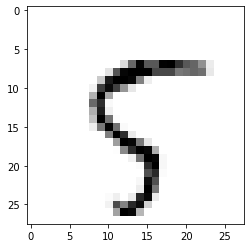

In [16]:
# Visualizando uma imagem da base de dados
dataiter = iter(trainloader)
imagens, etiquetas = dataiter.next()
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')

In [17]:
# Verificar as dimensões do tensor de cada imagem
print(imagens[0].shape)

# Verificar as dimensões do tensor de cada etiqueta
print(etiquetas[0].shape)

torch.Size([1, 28, 28])
torch.Size([])


In [18]:
class Modelo(nn.Module):
  def __init__(self):
    super(Modelo, self).__init__()
    self.linear1 = nn.Linear(28*28, 128)  # Camada de entrada, 784 neurônios que se ligam a 128
    self.linear2 = nn.Linear(128, 64)     # Camada interna 1, 128 neurônios que se ligam a 64
    self.linear3 = nn.Linear(64, 10)      # Camada interna 2, 64 neurônios que se ligam a 10
    
    # para a camada de saída não é necessário definir nada, pois só precisamos pegar o output da camanda interna 2

  def forward(self, X):
    X = F.relu(self.linear1(X))           # Função de ativação da camada de entrada para a camada interna 1
    X = F.relu(self.linear2(X))           # Função de ativação da camada interna 1 para a camada interna 2
    X = self.linear3(X)                   # Função de ativação da camada interna 2 para a camada de saída, nesse caso f(X)=X
    return F.log_softmax(X, dim=1)        # Dados utilizados para calcular a perda

In [19]:
def treino(modelo, trainloader, device):
  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5)   # Define a política de atualização dos pesos e da bias
  inicio = time()                                                      # Timer para sabermos quanto tempo levou o treino

  criterio = nn.NLLLoss()                                              # Defininfo o critério para calcular a perda
  EPOCHS = 10                                                          # Número de epochs que o algoritmo rodará
  modelo.train()                                                       # Ativando o modo de treinamento do modelo

  for epoch in range(EPOCHS):
    perda_acumulada = 0                                                # Inicialização da perda acumulada da epoch em questão

    for imagens, etiquetas in trainloader:
      imagens = imagens.view(imagens.shape[0], -1)                     # Convertendo as imagens para "vetores" de 28*28 casas para ficarem compatíveis com a...
      otimizador.zero_grad()                                           # Zerando os gradientes por conta do ciclo anterior

      output = modelo(imagens.to(device))                              # Colocando os dados no modelo
      perda_instantanea = criterio(output, etiquetas.to(device))       # Calculando a perda da epoch em questão

      perda_instantanea.backward()                                     # Backpropagation a partir da perda

      otimizador.step()                                                # Atualizando os pesos e a bias

      perda_acumulada += perda_instantanea.item()                      # Atualização da perda acumulada


    else:
      print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))

  print("\nTempo de treino (em minutos) =", (time()-inicio())/60)

In [20]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0,0
  
  for imagens, etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[i].view(1, 784)
      # desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos tem um custo alto de processamento
      with torch.no_grad():
        logps = modelo(img.to(device)) # output do modelo em escala logaritmica


      ps = torch.exp(logps) # converte output para escala normal(lembrando que é um tensor)
      probab = list(ps.cpu().numpy()[0])
      etiqueta_pred = probab.index(max(probab)) # converte o tensor em um número, no caso, o número que o modelo previu como correto
      etiqueta_certa = etiquetas.numpy()[i]

      if etiqueta_certa == etiqueta_pred: # compara a previsão com o valor correto
        conta_corretas += 1
      
      conta_todas += 1

  print("Total de imagens testadas = ", conta_todas)
  print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))

In [21]:
modelo = Modelo() # inicializa o modelo

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # modelo rodará na GPU se possível

modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)